### Basic Imports

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
# Retina mode
%config InlineBackend.figure_format = 'retina'

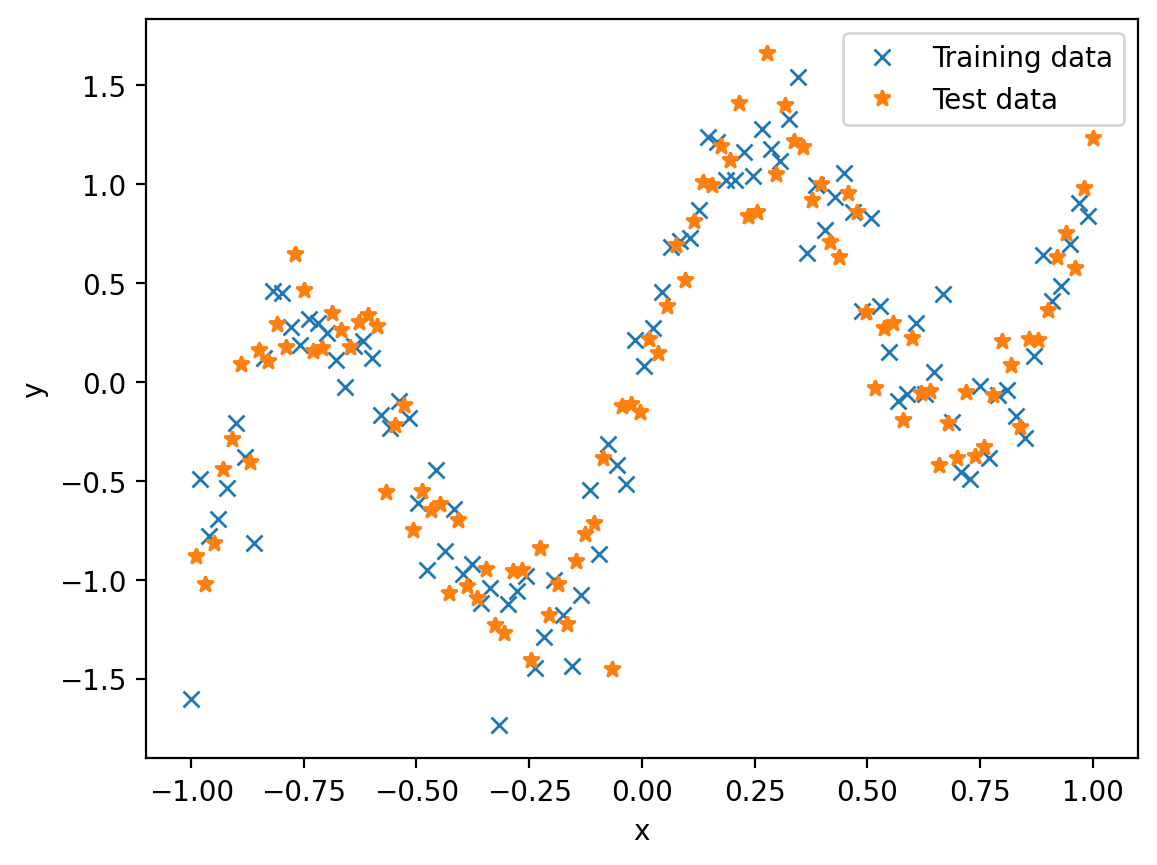

In [2]:
# Create training and test data
x_overall = torch.linspace(-1, 1, 200)

f_true = lambda x: torch.sin(2 * np.pi * x) + x

noise = torch.distributions.Normal(0, 0.2)

y_overall = f_true(x_overall) + noise.sample(x_overall.shape)

x_train = x_overall[::2]
y_train = y_overall[::2]

x_test = x_overall[1::2]
y_test = y_overall[1::2]

def plot_train_test():
    plt.plot(x_train, y_train, 'x', label='Training data')
    plt.plot(x_test, y_test, '*', label='Test data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plot_train_test()

In [3]:
def mean_function(x):
    return 0.0*x

def covariance_function(x1, x2):
    return torch.exp(-0.5 * (x1 - x2).pow(2))

In [4]:
mean_vector = mean_function(x_overall)
covariance_matrix = covariance_function(x_overall.unsqueeze(1), x_overall.unsqueeze(0))

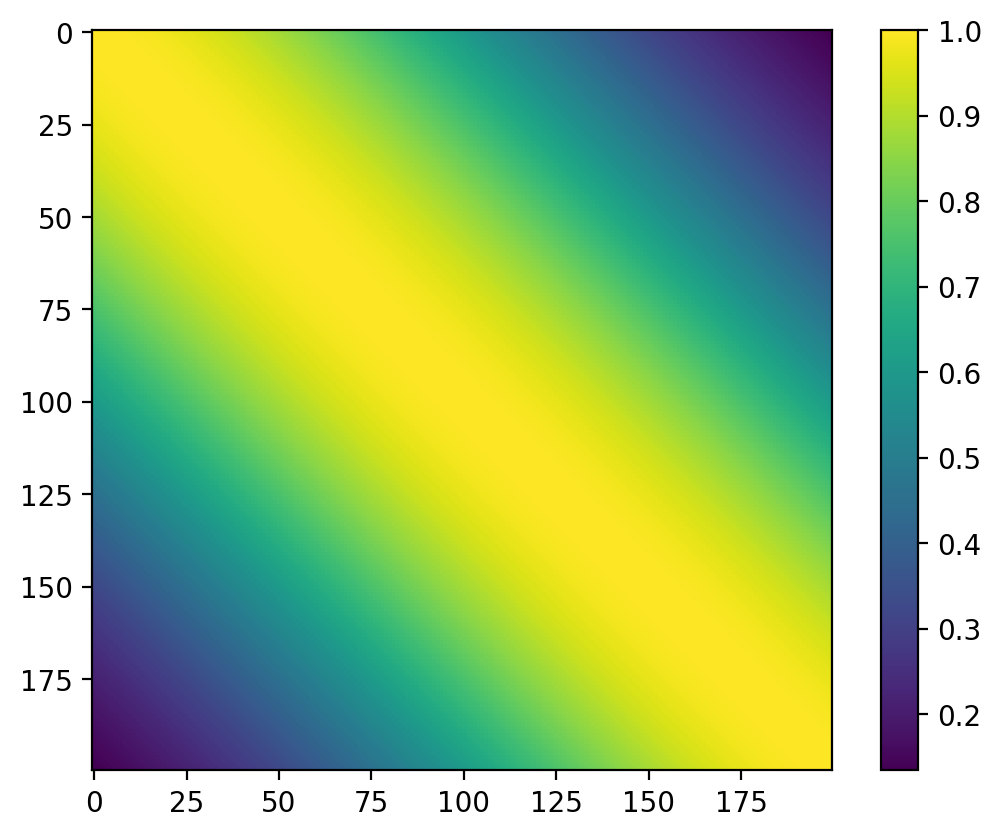

In [5]:
plt.imshow(covariance_matrix.detach().numpy())
plt.colorbar()

In [6]:
mvn = torch.distributions.MultivariateNormal(mean_vector, covariance_matrix + 1e-4 * torch.eye(len(x_overall)))
y_sample_overall = mvn.sample([500])

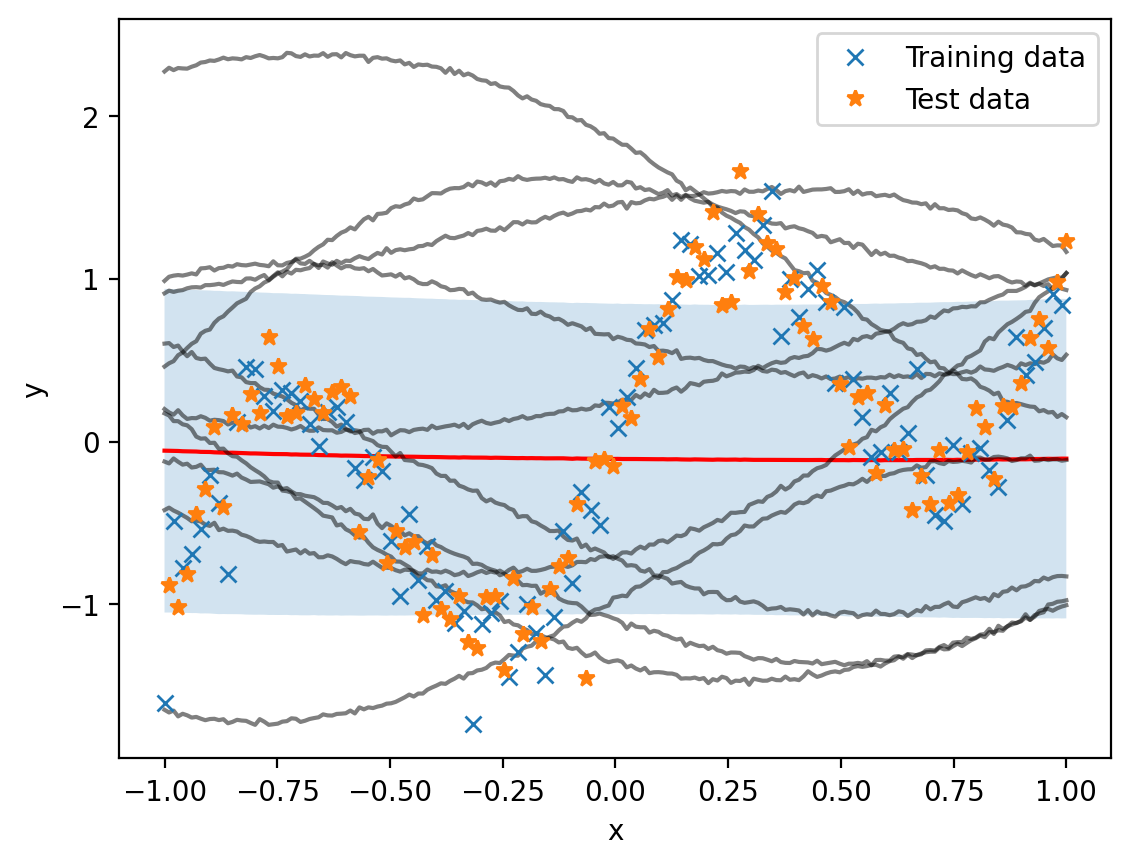

In [7]:
plt.plot(x_overall, y_sample_overall.mean(dim=0), color='r')
plt.fill_between(x_overall, y_sample_overall.mean(dim=0) - y_sample_overall.std(dim=0), 
                 y_sample_overall.mean(dim=0) + y_sample_overall.std(dim=0), alpha=0.2)

# Draw some samples
for i in range(10):
    plt.plot(x_overall, y_sample_overall[i], color='k', alpha=0.5)
    
plot_train_test()

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleMLP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        x = self.fc1(x)
        x = torch.sin(x)
        x = self.fc2(x)
        x = torch.sin(x)
        x = self.fc3(x)
        x = torch.sin(x)
        x = self.fc4(x)
        return x

In [9]:
mean_function = SimpleMLP(1, 10, 1)
cov_function = SimpleMLP(1, 10, 1)

torch.Size([200])
torch.Size([200, 200])


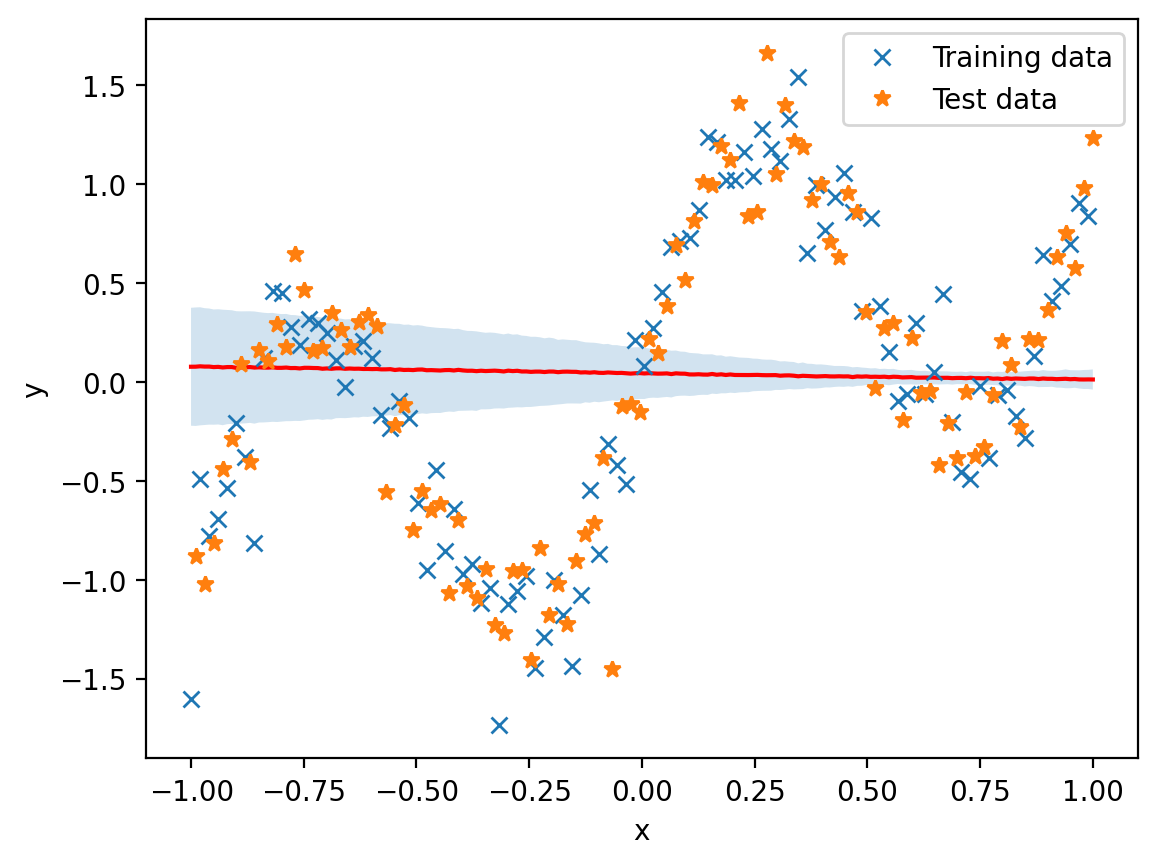

In [10]:
def plot_model(mean_function, cov_function, n_samples=0):
    mu = mean_function(x_overall).squeeze()
    print(mu.shape)
    L = cov_function(x_overall)
    L_transpose = torch.transpose(L, 0, 1)
    cov_nn = torch.mm(L, L_transpose)
    print(cov_nn.shape)
    
    mvn = torch.distributions.MultivariateNormal(mu, cov_nn + 1e-3 * torch.eye(len(mu)))
    y_sample_overall = mvn.sample([500])
    
    plt.plot(x_overall, y_sample_overall.mean(dim=0), color='r')
    plt.fill_between(x_overall, y_sample_overall.mean(dim=0) - y_sample_overall.std(dim=0), 
                    y_sample_overall.mean(dim=0) + y_sample_overall.std(dim=0), alpha=0.2)

    if n_samples > 0:
        # Draw some samples
        for i in range(n_samples):
            plt.plot(x_overall, y_sample_overall[i], color='k', alpha=0.5)
        
#plot_train_test()
    
plot_model(mean_function, cov_function)
plot_train_test()

torch.Size([200])
torch.Size([200, 200])


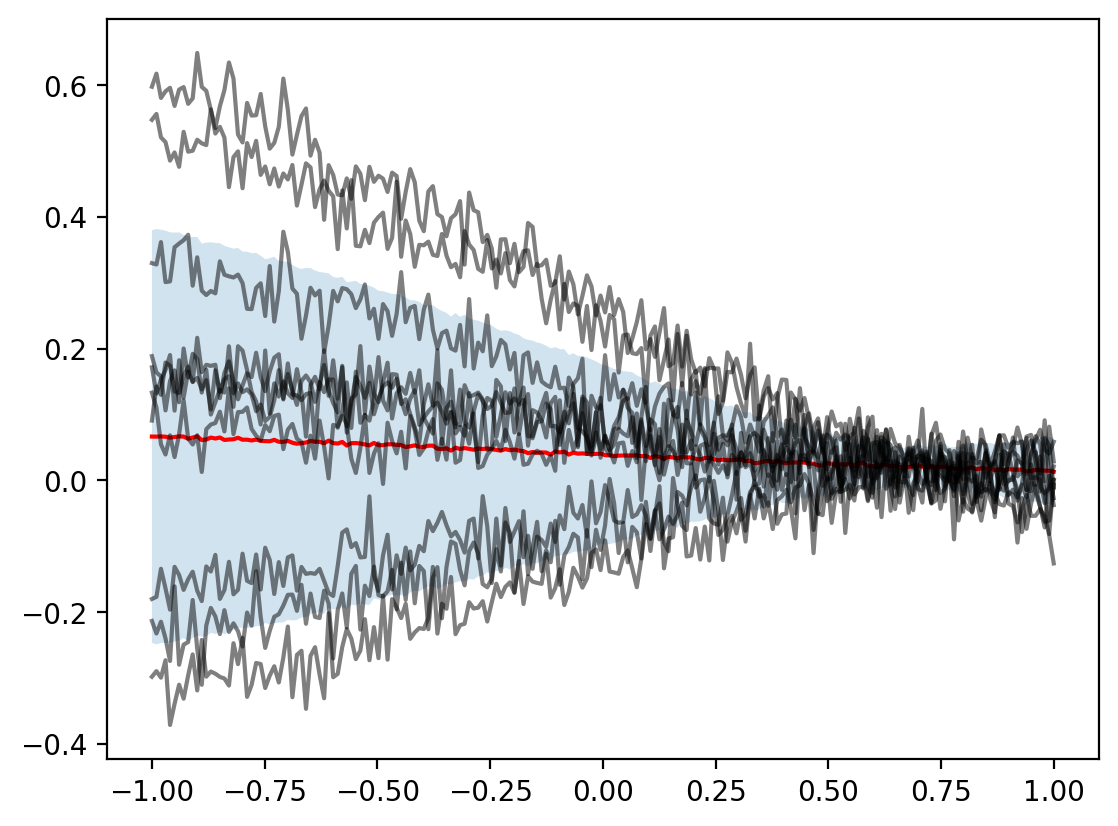

In [11]:
plot_model(mean_function, cov_function, n_samples=10)

In [12]:
# Train the models for mean and covariance

mean_function = SimpleMLP(1, 12, 1)
cov_function = SimpleMLP(1, 12, 1)

params = list(mean_function.parameters()) + list(cov_function.parameters())

optimizer = torch.optim.Adam(params, lr=1e-2)

n_epochs = 6000

for i in range(n_epochs):
    mu = mean_function(x_train.squeeze()).squeeze()
    L = cov_function(x_train.squeeze())
    L_transpose = torch.transpose(L, 0, 1)
    cov_nn = torch.mm(L, L_transpose)

    mvn = torch.distributions.MultivariateNormal(mu, cov_nn + 1e-3 * torch.eye(len(x_train)))
    
    loss = -mvn.log_prob(y_train).mean()
    if i%200 == 0:
        print(i, loss.item())
    
    
    loss.backward()
    optimizer.step()
    
    optimizer.zero_grad()
    


0 28416.58203125


200 2226.45703125
400 2104.8095703125
600 2084.00341796875
800 2081.75537109375
1000 2111.228515625
1200 2157.63525390625
1400 2074.7109375
1600 2064.028076171875
1800 2079.3447265625
2000 2040.37158203125
2200 2034.6796875
2400 2033.635009765625
2600 2030.19921875
2800 2030.730712890625
3000 2032.0128173828125
3200 2030.2120361328125
3400 2029.049072265625
3600 2027.9500732421875
3800 2026.4254150390625
4000 2032.843994140625
4200 2028.046142578125
4400 2051.522216796875
4600 2026.2406005859375
4800 2025.3114013671875
5000 2023.988037109375
5200 2022.708740234375
5400 2023.7421875
5600 2023.27490234375
5800 2020.952392578125


torch.Size([200])
torch.Size([200, 200])


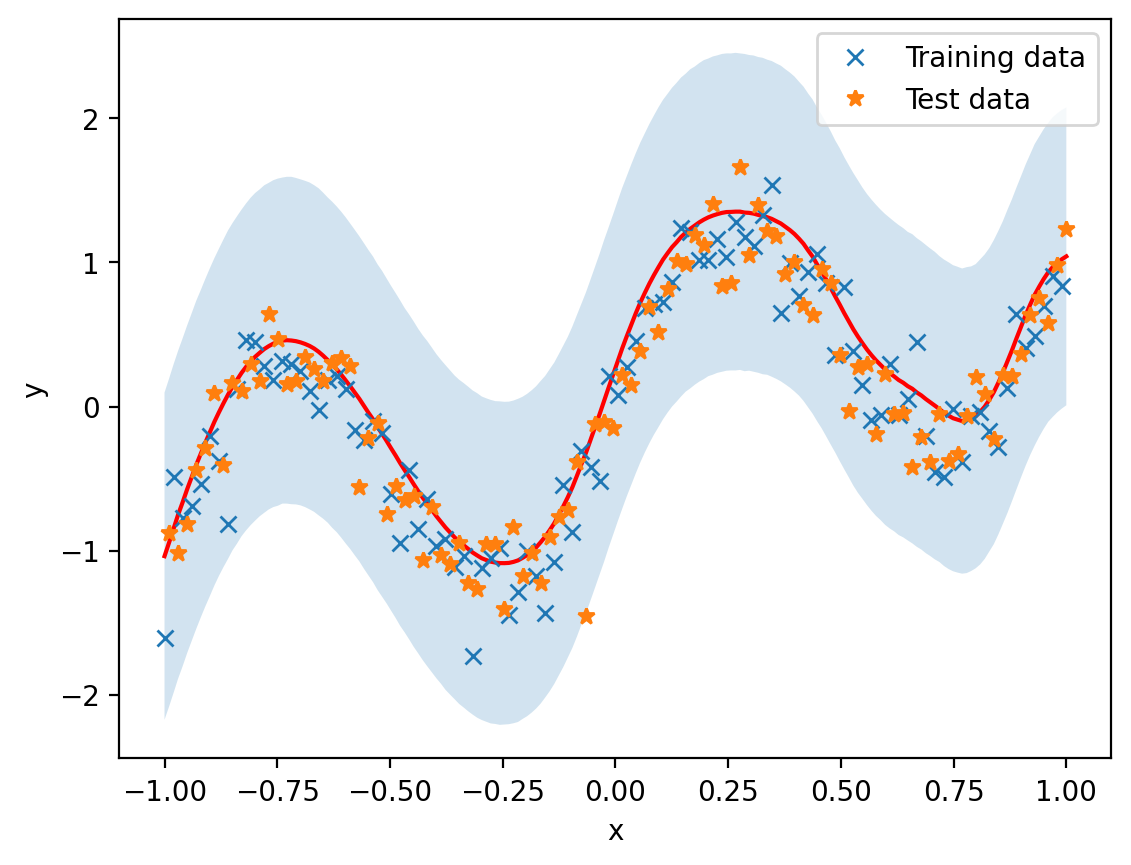

In [13]:
plot_model(mean_function, cov_function)
plot_train_test()